# 8 Pilares Estadisticos: Evaluacion de Balance Publico

**Traduciendo conceptos academicos para Data Science al mundo real**

Este notebook evalua el procesamiento de Balance Publico realizado por `ETL_Principales.py`, aplicando los 8 pilares estadisticos fundamentales:

1. **Distribuciones** - Forma de los datos
2. **Centro de Gravedad** - Media, Mediana, Moda
3. **Fiabilidad** - Riesgo y volatilidad
4. **Margen de Error** - Intervalos de confianza
5. **Pruebas de Hipotesis** - Chi-cuadrada
6. **Regresion/Prediccion** - Machine Learning
7. **Series de Tiempo** - Tendencias y estacionalidad
8. **ANOVA** - Comparacion entre grupos

In [1]:
# Importaciones
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from scipy.stats import chi2_contingency, shapiro, normaltest, kruskal
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

# Configuracion de graficos
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Rutas
BASE_DIR = Path('..').resolve()
DATOS_RESULTADO = BASE_DIR / 'Datos_Resultado'

print(f"Directorio base: {BASE_DIR}")
print(f"Datos resultado: {DATOS_RESULTADO}")

Directorio base: C:\Users\ARTUROJF\Desktop\Final
Datos resultado: C:\Users\ARTUROJF\Desktop\Final\Datos_Resultado


## Carga de Datos

Cargamos los datos procesados por ETL_Principales.py

In [2]:
# ============================================================================
# CARGAR DATOS PROCESADOS
# ============================================================================

path_procesado = DATOS_RESULTADO / 'balance_publico_agregados.csv'
df = pd.read_csv(path_procesado) if path_procesado.exists() else pd.DataFrame()

print(f"Datos procesados: {len(df)} filas x {len(df.columns)} columnas")
print(f"\nColumnas:")
print(df.columns.tolist())
print(f"\nPrimeras filas:")
df.head(10)

Datos procesados: 143 filas x 6 columnas

Columnas:
['periodo', 'CICLO', 'TRIMESTRE', 'ingresos_mmxn', 'gasto_mmxn', 'balance_mmxn']

Primeras filas:


,periodo,CICLO,TRIMESTRE,ingresos_mmxn,gasto_mmxn,balance_mmxn
0,1990-01-01,1990,1,42560.899,49099.137,-8170.824
1,1990-04-01,1990,2,42816.451,45663.782,-1763.987
2,1990-07-01,1990,3,45927.963,47555.025,-1595.793
3,1990-10-01,1990,4,56396.280,61897.380,-7735.563
4,1991-01-01,1991,1,59919.261,51665.573,6205.216
5,1991-04-01,1991,2,62457.282,51692.658,10637.280
6,1991-07-01,1991,3,64334.593,54889.609,9951.422
7,1991-10-01,1991,4,67671.895,69685.310,-1604.621
8,1992-01-01,1992,1,73490.572,55978.699,19671.631
9,1992-04-01,1992,2,75344.154,54274.990,19998.422


In [3]:
# Preparar datos para analisis
df['periodo'] = pd.to_datetime(df['periodo'])
df = df.sort_values('periodo').reset_index(drop=True)

# Variables numericas principales
cols_numericas = ['ingresos_mmxn', 'gasto_mmxn', 'balance_mmxn']
print(f"Variables numericas para analisis: {cols_numericas}")

# Variable principal: balance
VAR_PRINCIPAL = 'balance_mmxn'
print(f"\nVariable principal: {VAR_PRINCIPAL}")
print(f"Rango: {df[VAR_PRINCIPAL].min():.2f} - {df[VAR_PRINCIPAL].max():.2f} millones MXN")
print(f"\nEstadisticas descriptivas:")
df[cols_numericas].describe()

Variables numericas para analisis: ['ingresos_mmxn', 'gasto_mmxn', 'balance_mmxn']

Variable principal: balance_mmxn
Rango: -676773.05 - 309068.76 millones MXN

Estadisticas descriptivas:


,ingresos_mmxn,gasto_mmxn,balance_mmxn
count,1.430000e+02,1.430000e+02,143.000000
mean,7.294680e+05,8.036571e+05,-73686.450844
std,5.621701e+05,6.548725e+05,129817.671087
min,4.256090e+04,4.566378e+04,-676773.050470
25%,2.228370e+05,2.360320e+05,-122479.303471
50%,6.496434e+05,6.574770e+05,-32111.400000
75%,1.169223e+06,1.305316e+06,7554.991000
max,2.149137e+06,2.455822e+06,309068.755171


---
## PILAR 1: Distribuciones - ¿Que forma tienen los datos?

**Objetivo:** Identificar si los datos siguen una distribucion normal o requieren transformacion.

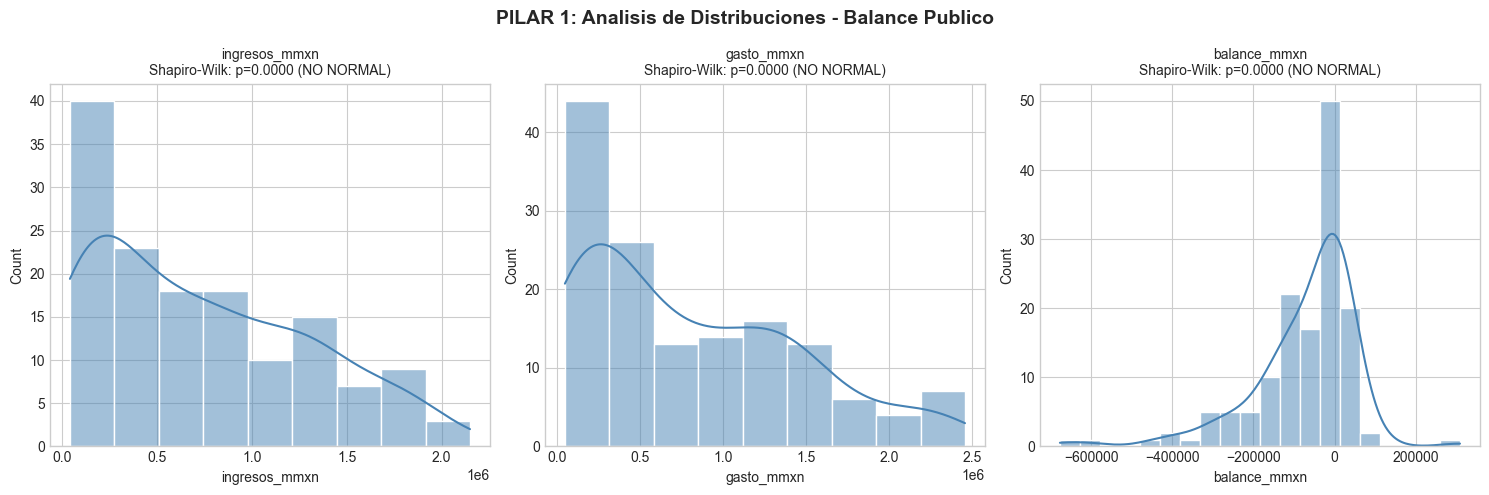


RESUMEN DE NORMALIDAD
ingresos_mmxn: p=0.0000 | Sesgo=0.57 | Curtosis=-0.77 | No Normal
gasto_mmxn: p=0.0000 | Sesgo=0.70 | Curtosis=-0.49 | No Normal
balance_mmxn: p=0.0000 | Sesgo=-1.66 | Curtosis=4.94 | No Normal


In [4]:
# ============================================================================
# PILAR 1: DISTRIBUCIONES
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('PILAR 1: Analisis de Distribuciones - Balance Publico', fontsize=14, fontweight='bold')

for idx, var in enumerate(cols_numericas):
    ax = axes[idx]
    data = df[var].dropna()
    
    # Histograma con KDE
    sns.histplot(data, kde=True, ax=ax, color='steelblue', edgecolor='white')
    
    # Test de normalidad
    if len(data) >= 20:
        stat, p_value = shapiro(data) if len(data) < 5000 else normaltest(data)
        test_name = 'Shapiro-Wilk' if len(data) < 5000 else "D'Agostino"
        normalidad = 'NORMAL' if p_value > 0.05 else 'NO NORMAL'
        ax.set_title(f'{var}\n{test_name}: p={p_value:.4f} ({normalidad})', fontsize=10)
    else:
        ax.set_title(f'{var}\n(datos insuficientes)', fontsize=10)

plt.tight_layout()
plt.show()

# Resumen de normalidad
print("\n" + "="*60)
print("RESUMEN DE NORMALIDAD")
print("="*60)
for var in cols_numericas:
    data = df[var].dropna()
    if len(data) >= 20:
        stat, p = shapiro(data) if len(data) < 5000 else normaltest(data)
        skew = data.skew()
        kurt = data.kurtosis()
        print(f"{var}: p={p:.4f} | Sesgo={skew:.2f} | Curtosis={kurt:.2f} | {'Normal' if p>0.05 else 'No Normal'}")

---
## PILAR 2: Centro de Gravedad - ¿Donde esta el comportamiento tipico?

**Objetivo:** Identificar Media, Mediana y Moda de las variables principales.

PILAR 2: MEDIDAS DE TENDENCIA CENTRAL
     Variable         Media     Mediana          Moda  Diferencia Media-Mediana (%)
ingresos_mmxn 729468.048821 649643.3630   42560.89900                     12.287463
   gasto_mmxn 803657.143774 657477.0398   45663.78200                     22.233492
 balance_mmxn -73686.450844 -32111.4000 -676773.05047                   -129.471312


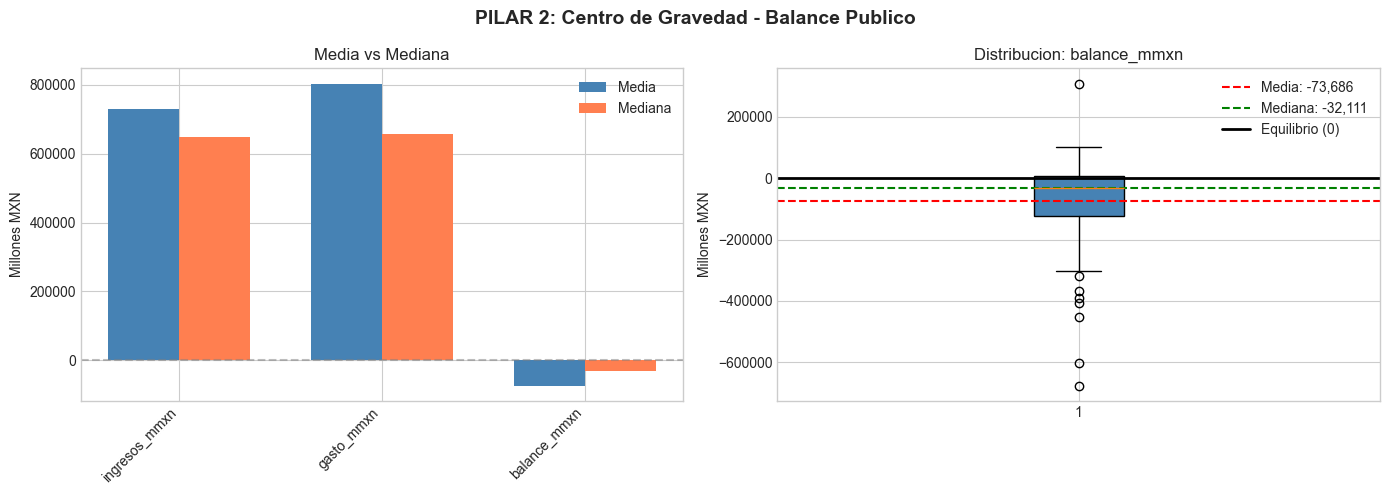

In [5]:
# ============================================================================
# PILAR 2: CENTRO DE GRAVEDAD
# ============================================================================

print("PILAR 2: MEDIDAS DE TENDENCIA CENTRAL")
print("="*80)

# Calcular estadisticas para todas las variables
stats_centro = []
for var in cols_numericas:
    data = df[var].dropna()
    if len(data) > 0:
        stats_centro.append({
            'Variable': var,
            'Media': data.mean(),
            'Mediana': data.median(),
            'Moda': data.mode().iloc[0] if len(data.mode()) > 0 else np.nan,
            'Diferencia Media-Mediana (%)': ((data.mean() - data.median()) / abs(data.median()) * 100) if data.median() != 0 else 0
        })

df_centro = pd.DataFrame(stats_centro)
print(df_centro.to_string(index=False))

# Visualizacion
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('PILAR 2: Centro de Gravedad - Balance Publico', fontsize=14, fontweight='bold')

# Grafico 1: Comparacion Media vs Mediana
x = np.arange(len(df_centro))
width = 0.35
axes[0].bar(x - width/2, df_centro['Media'], width, label='Media', color='steelblue')
axes[0].bar(x + width/2, df_centro['Mediana'], width, label='Mediana', color='coral')
axes[0].set_xticks(x)
axes[0].set_xticklabels(df_centro['Variable'], rotation=45, ha='right')
axes[0].set_ylabel('Millones MXN')
axes[0].set_title('Media vs Mediana')
axes[0].legend()
axes[0].axhline(0, color='gray', linestyle='--', alpha=0.5)

# Grafico 2: Boxplot de balance
data_principal = df[VAR_PRINCIPAL].dropna()
bp = axes[1].boxplot(data_principal, patch_artist=True)
bp['boxes'][0].set_facecolor('steelblue')
axes[1].axhline(data_principal.mean(), color='red', linestyle='--', label=f'Media: {data_principal.mean():,.0f}')
axes[1].axhline(data_principal.median(), color='green', linestyle='--', label=f'Mediana: {data_principal.median():,.0f}')
axes[1].axhline(0, color='black', linestyle='-', linewidth=2, label='Equilibrio (0)')
axes[1].set_ylabel('Millones MXN')
axes[1].set_title(f'Distribucion: {VAR_PRINCIPAL}')
axes[1].legend()

plt.tight_layout()
plt.show()

---
## PILAR 3: Fiabilidad - ¿Que tan confiables son los datos?

**Objetivo:** Medir riesgo, volatilidad y detectar anomalias.

PILAR 3: MEDIDAS DE DISPERSION Y FIABILIDAD
     Variable     Desv. Std     CV (%)        Rango          IQR  Outliers  % Outliers
ingresos_mmxn 562170.070159  77.065756 2.106577e+06 9.463861e+05         0    0.000000
   gasto_mmxn 654872.472602  81.486549 2.410158e+06 1.069284e+06         0    0.000000
 balance_mmxn 129817.671087 176.175769 9.858418e+05 1.300343e+05         8    5.594406


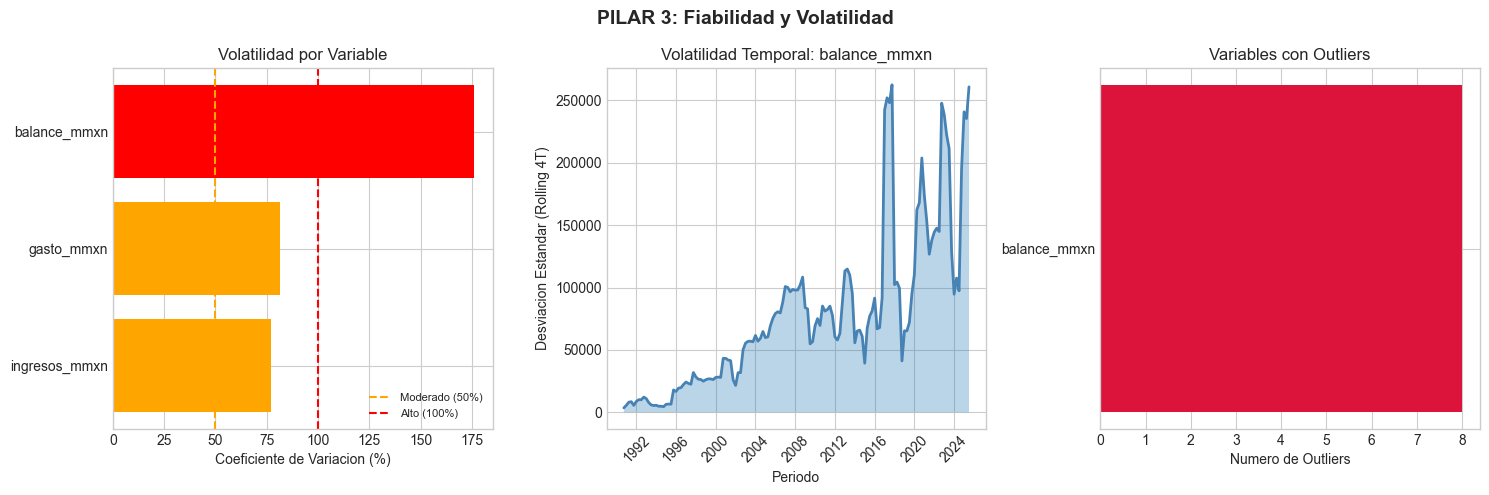

In [6]:
# ============================================================================
# PILAR 3: FIABILIDAD - RIESGO Y VOLATILIDAD
# ============================================================================

print("PILAR 3: MEDIDAS DE DISPERSION Y FIABILIDAD")
print("="*80)

# Calcular metricas de fiabilidad
stats_fiabilidad = []
for var in cols_numericas:
    data = df[var].dropna()
    if len(data) > 0:
        # Coeficiente de variacion (CV) - usar valor absoluto de media para balance
        cv = (data.std() / abs(data.mean()) * 100) if data.mean() != 0 else np.nan
        
        # Deteccion de outliers (IQR)
        Q1, Q3 = data.quantile([0.25, 0.75])
        IQR = Q3 - Q1
        outliers = ((data < Q1 - 1.5*IQR) | (data > Q3 + 1.5*IQR)).sum()
        
        stats_fiabilidad.append({
            'Variable': var,
            'Desv. Std': data.std(),
            'CV (%)': cv,
            'Rango': data.max() - data.min(),
            'IQR': IQR,
            'Outliers': outliers,
            '% Outliers': outliers / len(data) * 100
        })

df_fiabilidad = pd.DataFrame(stats_fiabilidad)
print(df_fiabilidad.to_string(index=False))

# Visualizacion
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('PILAR 3: Fiabilidad y Volatilidad', fontsize=14, fontweight='bold')

# Grafico 1: Coeficiente de Variacion
colors = ['red' if cv > 100 else 'orange' if cv > 50 else 'green' for cv in df_fiabilidad['CV (%)']]
axes[0].barh(df_fiabilidad['Variable'], df_fiabilidad['CV (%)'], color=colors)
axes[0].axvline(50, color='orange', linestyle='--', label='Moderado (50%)')
axes[0].axvline(100, color='red', linestyle='--', label='Alto (100%)')
axes[0].set_xlabel('Coeficiente de Variacion (%)')
axes[0].set_title('Volatilidad por Variable')
axes[0].legend(fontsize=8)

# Grafico 2: Evolucion temporal de volatilidad (rolling std)
rolling_std = df[VAR_PRINCIPAL].rolling(window=4).std()
axes[1].plot(df['periodo'], rolling_std, color='steelblue', linewidth=2)
axes[1].fill_between(df['periodo'], rolling_std, alpha=0.3)
axes[1].set_xlabel('Periodo')
axes[1].set_ylabel('Desviacion Estandar (Rolling 4T)')
axes[1].set_title(f'Volatilidad Temporal: {VAR_PRINCIPAL}')
axes[1].tick_params(axis='x', rotation=45)

# Grafico 3: Deteccion de outliers
outlier_vars = df_fiabilidad[df_fiabilidad['Outliers'] > 0]
if len(outlier_vars) > 0:
    axes[2].barh(outlier_vars['Variable'], outlier_vars['Outliers'], color='crimson')
    axes[2].set_xlabel('Numero de Outliers')
    axes[2].set_title('Variables con Outliers')
else:
    axes[2].text(0.5, 0.5, 'Sin outliers detectados', ha='center', va='center', transform=axes[2].transAxes)
    axes[2].set_title('Variables con Outliers')

plt.tight_layout()
plt.show()

---
## PILAR 4: Margen de Error - Intervalos de Confianza

**Objetivo:** Proporcionar rangos probables con certeza estadistica.

PILAR 4: INTERVALOS DE CONFIANZA (95%)
     Variable         Media  IC 95% Inferior  IC 95% Superior  Margen de Error  Margen (%)
ingresos_mmxn 729468.048821    636536.141845    822399.955797     92931.906976   12.739682
   gasto_mmxn 803657.143774    695400.673116    911913.614432    108256.470658   13.470479
 balance_mmxn -73686.450844    -95146.511373    -52226.390315     21460.060529   29.123482


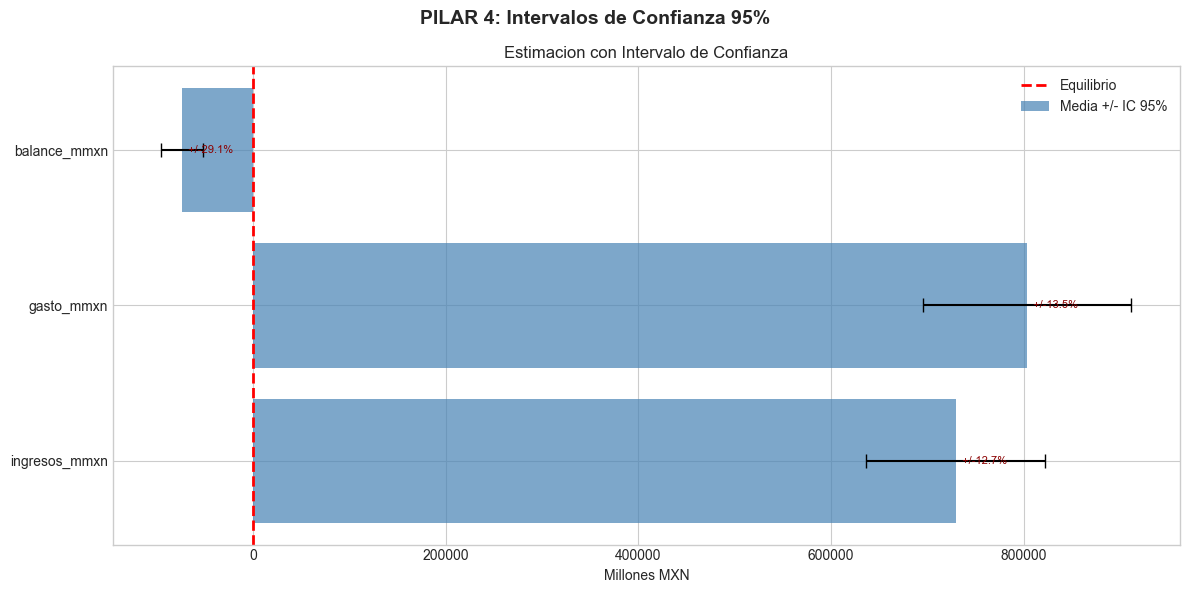

In [7]:
# ============================================================================
# PILAR 4: MARGEN DE ERROR - INTERVALOS DE CONFIANZA
# ============================================================================

print("PILAR 4: INTERVALOS DE CONFIANZA (95%)")
print("="*80)

def intervalo_confianza(data, confianza=0.95):
    """Calcula intervalo de confianza para la media."""
    n = len(data)
    media = data.mean()
    sem = stats.sem(data)  # Error estandar de la media
    h = sem * stats.t.ppf((1 + confianza) / 2, n - 1)
    return media - h, media + h, h

# Calcular IC para variables principales
ic_results = []
for var in cols_numericas:
    data = df[var].dropna()
    if len(data) >= 10:
        ic_low, ic_high, margen = intervalo_confianza(data)
        ic_results.append({
            'Variable': var,
            'Media': data.mean(),
            'IC 95% Inferior': ic_low,
            'IC 95% Superior': ic_high,
            'Margen de Error': margen,
            'Margen (%)': abs(margen / data.mean() * 100) if data.mean() != 0 else 0
        })

df_ic = pd.DataFrame(ic_results)
print(df_ic.to_string(index=False))

# Visualizacion
fig, ax = plt.subplots(figsize=(12, 6))
fig.suptitle('PILAR 4: Intervalos de Confianza 95%', fontsize=14, fontweight='bold')

y_pos = np.arange(len(df_ic))
ax.barh(y_pos, df_ic['Media'], xerr=df_ic['Margen de Error'], 
        color='steelblue', alpha=0.7, capsize=5, label='Media +/- IC 95%')
ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Equilibrio')
ax.set_yticks(y_pos)
ax.set_yticklabels(df_ic['Variable'])
ax.set_xlabel('Millones MXN')
ax.set_title('Estimacion con Intervalo de Confianza')
ax.legend()

# Agregar valores
for i, (media, margen) in enumerate(zip(df_ic['Media'], df_ic['Margen (%)'])):
    ax.text(media, i, f'  +/-{margen:.1f}%', va='center', fontsize=8, color='darkred')

plt.tight_layout()
plt.show()

---
## PILAR 5: Pruebas de Hipotesis - ¿Fue suerte o fue real?

**Objetivo:** Validar afirmaciones con evidencia estadistica usando Chi-Cuadrada.

In [8]:
# ============================================================================
# PILAR 5: PRUEBAS DE HIPOTESIS - CHI-CUADRADA
# ============================================================================

print("PILAR 5: PRUEBAS DE HIPOTESIS")
print("="*80)

# Hipotesis 1: ¿El resultado fiscal (superavit/deficit) es independiente del trimestre?
print("\n--- HIPOTESIS 1: Independencia Resultado Fiscal vs Trimestre ---")
print("H0: El resultado fiscal (superavit/deficit) es independiente del trimestre")
print("H1: El resultado fiscal depende del trimestre")

# Crear variable categorica: superavit o deficit
df_test = df.copy()
df_test['resultado_fiscal'] = df_test['balance_mmxn'].apply(lambda x: 'Superavit' if x > 0 else 'Deficit')

# Tabla de contingencia
contingencia = pd.crosstab(df_test['resultado_fiscal'], df_test['TRIMESTRE'])
print("\nTabla de Contingencia:")
print(contingencia)

# Test Chi-cuadrada
chi2, p_value, dof, expected = chi2_contingency(contingencia)
print(f"\nEstadistico Chi-cuadrada: {chi2:.4f}")
print(f"Grados de libertad: {dof}")
print(f"p-value: {p_value:.4f}")
print(f"\nConclusion: {'RECHAZAR H0' if p_value < 0.05 else 'NO RECHAZAR H0'} (alfa=0.05)")
if p_value < 0.05:
    print("-> Existe dependencia significativa entre resultado fiscal y trimestre")
else:
    print("-> No hay evidencia de dependencia entre resultado fiscal y trimestre")

PILAR 5: PRUEBAS DE HIPOTESIS

--- HIPOTESIS 1: Independencia Resultado Fiscal vs Trimestre ---
H0: El resultado fiscal (superavit/deficit) es independiente del trimestre
H1: El resultado fiscal depende del trimestre

Tabla de Contingencia:
TRIMESTRE          1   2   3   4
resultado_fiscal                
Deficit           14  21  25  35
Superavit         22  15  11   0

Estadistico Chi-cuadrada: 31.1384
Grados de libertad: 3
p-value: 0.0000

Conclusion: RECHAZAR H0 (alfa=0.05)
-> Existe dependencia significativa entre resultado fiscal y trimestre


In [9]:
# Hipotesis 2: ¿El comportamiento fiscal cambio antes/despues de 2010?
print("\n--- HIPOTESIS 2: Cambio estructural 2010 ---")
print("H0: El resultado fiscal es independiente del periodo (pre/post 2010)")
print("H1: El resultado fiscal depende del periodo")

df_test['era'] = df_test['periodo'].apply(lambda x: 'Pre-2010' if x.year < 2010 else 'Post-2010')

# Tabla de contingencia
contingencia2 = pd.crosstab(df_test['resultado_fiscal'], df_test['era'])
print("\nTabla de Contingencia (Resultado vs Era):")
print(contingencia2)

if contingencia2.shape[0] > 1 and contingencia2.shape[1] > 1:
    chi2_2, p_value_2, dof_2, expected_2 = chi2_contingency(contingencia2)
    print(f"\nEstadistico Chi-cuadrada: {chi2_2:.4f}")
    print(f"p-value: {p_value_2:.4f}")
    print(f"\nConclusion: {'RECHAZAR H0' if p_value_2 < 0.05 else 'NO RECHAZAR H0'} (alfa=0.05)")
else:
    print("Datos insuficientes para el test")
    p_value_2 = 1.0


--- HIPOTESIS 2: Cambio estructural 2010 ---
H0: El resultado fiscal es independiente del periodo (pre/post 2010)
H1: El resultado fiscal depende del periodo

Tabla de Contingencia (Resultado vs Era):
era               Post-2010  Pre-2010
resultado_fiscal                     
Deficit                  58        37
Superavit                 5        43

Estadistico Chi-cuadrada: 31.1506
p-value: 0.0000

Conclusion: RECHAZAR H0 (alfa=0.05)


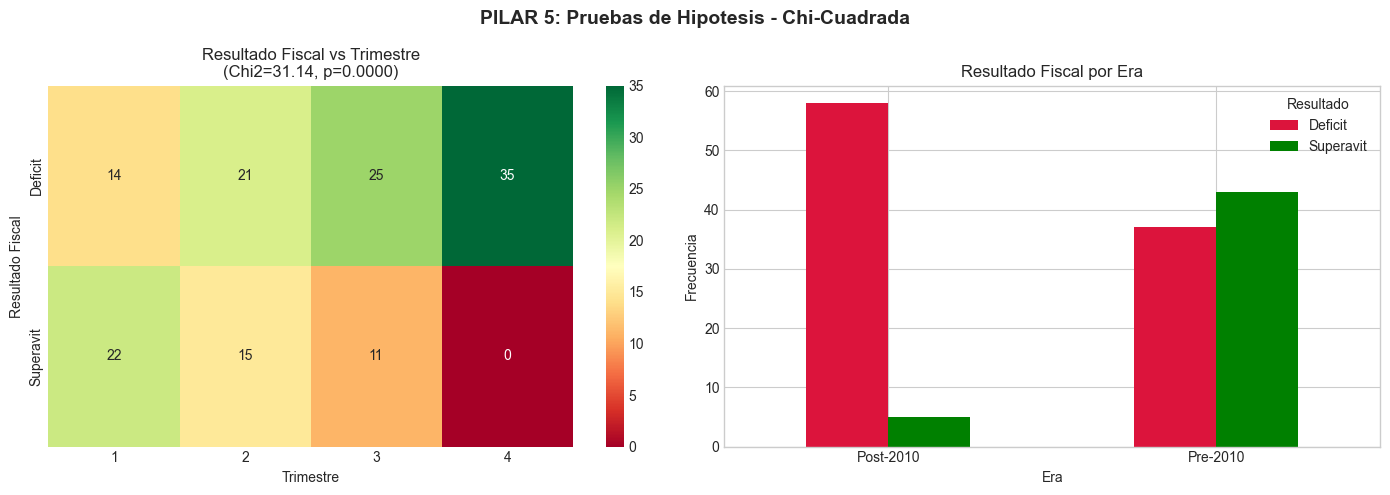

In [10]:
# Visualizacion de pruebas de hipotesis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('PILAR 5: Pruebas de Hipotesis - Chi-Cuadrada', fontsize=14, fontweight='bold')

# Grafico 1: Heatmap de contingencia 1
sns.heatmap(contingencia, annot=True, fmt='d', cmap='RdYlGn', ax=axes[0])
axes[0].set_title(f'Resultado Fiscal vs Trimestre\n(Chi2={chi2:.2f}, p={p_value:.4f})')
axes[0].set_xlabel('Trimestre')
axes[0].set_ylabel('Resultado Fiscal')

# Grafico 2: Distribucion por era
era_counts = df_test.groupby(['era', 'resultado_fiscal']).size().unstack(fill_value=0)
era_counts.plot(kind='bar', ax=axes[1], color=['crimson', 'green'])
axes[1].set_title('Resultado Fiscal por Era')
axes[1].set_xlabel('Era')
axes[1].set_ylabel('Frecuencia')
axes[1].tick_params(axis='x', rotation=0)
axes[1].legend(title='Resultado')

plt.tight_layout()
plt.show()

---
## PILAR 6: Regresion/Prediccion - ¿Como predecir el futuro?

**Objetivo:** Modelar relaciones para anticipar resultados usando Machine Learning.

In [11]:
# ============================================================================
# PILAR 6: PREDICCION CON MACHINE LEARNING
# ============================================================================

print("PILAR 6: MODELOS DE PREDICCION - MACHINE LEARNING")
print("="*80)

# Preparar datos para prediccion
# Objetivo: Predecir balance usando ingresos, gasto y trimestre

# Crear features adicionales
df_ml = df.copy()
df_ml['year'] = df_ml['periodo'].dt.year
df_ml['month'] = df_ml['periodo'].dt.month

# Features y target
features = ['ingresos_mmxn', 'gasto_mmxn', 'TRIMESTRE', 'year']
target = 'balance_mmxn'

print(f"Features para modelo: {features}")
print(f"Target: {target}")

# Preparar dataset
df_ml = df_ml[features + [target]].dropna()
X = df_ml[features]
y = df_ml[target]

print(f"\nDatos para entrenamiento: {len(df_ml)} observaciones")

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

PILAR 6: MODELOS DE PREDICCION - MACHINE LEARNING
Features para modelo: ['ingresos_mmxn', 'gasto_mmxn', 'TRIMESTRE', 'year']
Target: balance_mmxn

Datos para entrenamiento: 143 observaciones


In [12]:
# Entrenar multiples modelos
modelos = {
    'Regresion Lineal': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

resultados = []
predicciones = {}

for nombre, modelo in modelos.items():
    # Entrenar
    if 'Forest' in nombre or 'Boosting' in nombre:
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)
    else:
        modelo.fit(X_train_scaled, y_train)
        y_pred = modelo.predict(X_test_scaled)
    
    # Metricas
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    resultados.append({
        'Modelo': nombre,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'MAPE (%)': (mae / abs(y_test.mean()) * 100) if y_test.mean() != 0 else np.nan
    })
    predicciones[nombre] = y_pred

df_resultados = pd.DataFrame(resultados).sort_values('R2', ascending=False)
print("\nCOMPARACION DE MODELOS:")
print(df_resultados.to_string(index=False))

# Mejor modelo
mejor_modelo = df_resultados.iloc[0]['Modelo']
print(f"\n*** MEJOR MODELO: {mejor_modelo} (R2 = {df_resultados.iloc[0]['R2']:.4f}) ***")


COMPARACION DE MODELOS:
           Modelo         RMSE          MAE       R2  MAPE (%)
 Regresion Lineal 14406.209253 10147.752122 0.986531 15.805276
            Ridge 36770.890990 23667.599279 0.912250 36.862640
Gradient Boosting 45541.083112 24751.743985 0.865400 38.551211
    Random Forest 48195.852964 22658.532556 0.849250 35.291003

*** MEJOR MODELO: Regresion Lineal (R2 = 0.9865) ***


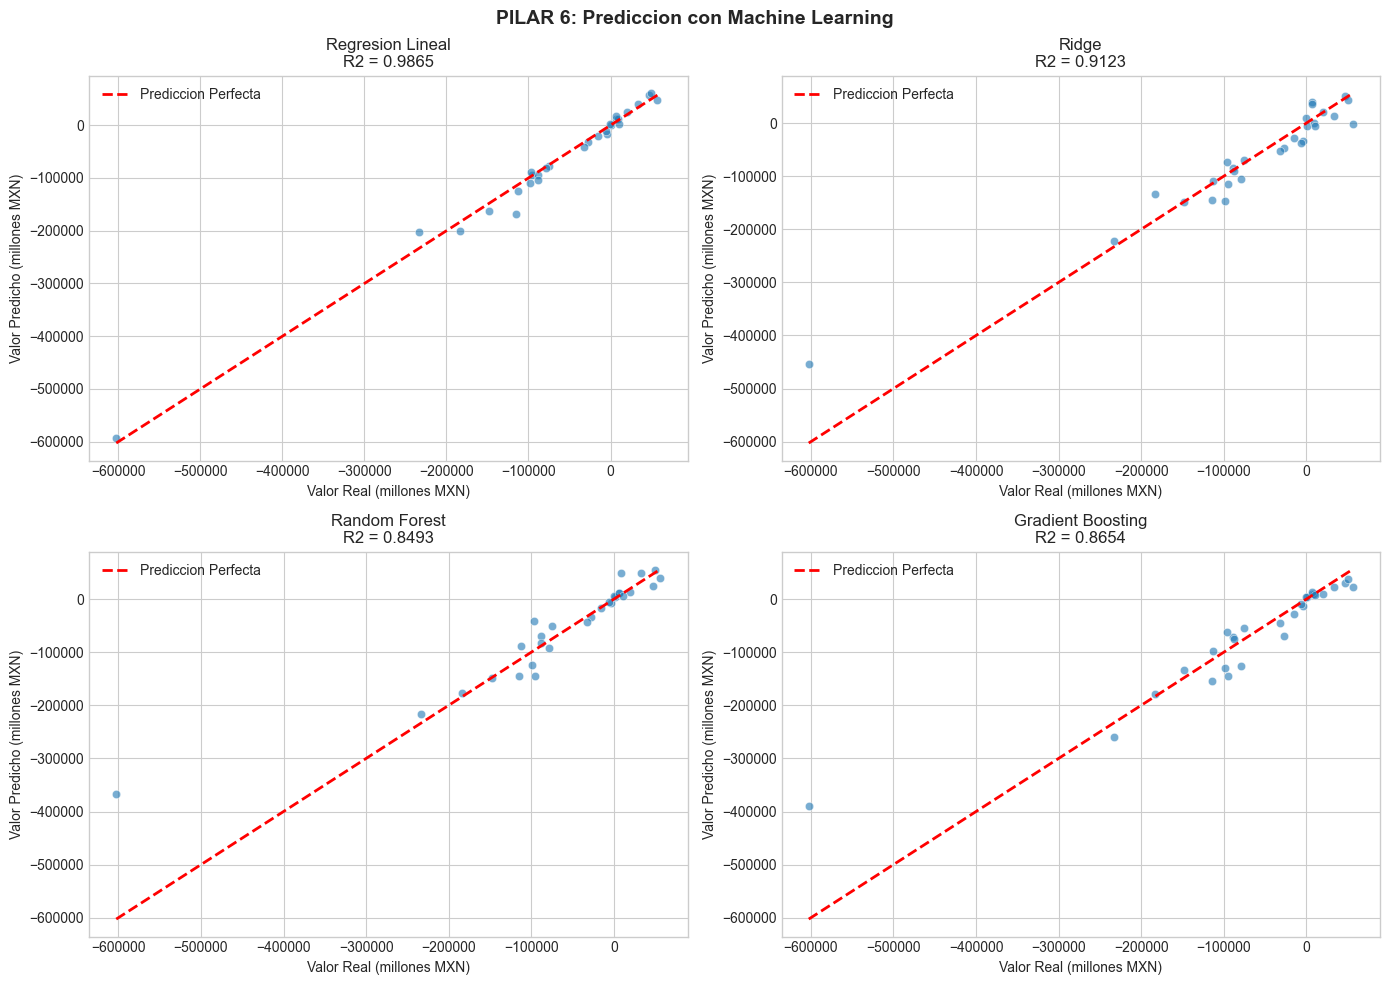

In [13]:
# Visualizacion de predicciones
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('PILAR 6: Prediccion con Machine Learning', fontsize=14, fontweight='bold')

for idx, (nombre, y_pred) in enumerate(predicciones.items()):
    ax = axes[idx // 2, idx % 2]
    ax.scatter(y_test, y_pred, alpha=0.6, edgecolors='white', linewidth=0.5)
    
    # Linea de referencia perfecta
    min_val, max_val = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Prediccion Perfecta')
    
    # Metricas
    r2 = r2_score(y_test, y_pred)
    ax.set_xlabel('Valor Real (millones MXN)')
    ax.set_ylabel('Valor Predicho (millones MXN)')
    ax.set_title(f'{nombre}\nR2 = {r2:.4f}')
    ax.legend()

plt.tight_layout()
plt.show()


IMPORTANCIA DE VARIABLES (Random Forest):
      Feature  Importancia
   gasto_mmxn     0.720720
    TRIMESTRE     0.117767
ingresos_mmxn     0.112902
         year     0.048612


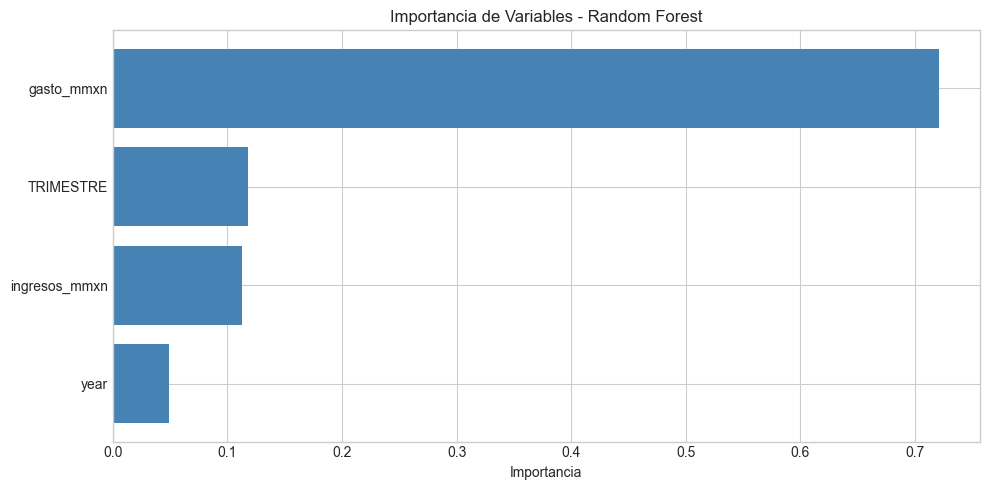

In [14]:
# Importancia de features (Random Forest)
rf_model = modelos['Random Forest']
importancia = pd.DataFrame({
    'Feature': features,
    'Importancia': rf_model.feature_importances_
}).sort_values('Importancia', ascending=False)

print("\nIMPORTANCIA DE VARIABLES (Random Forest):")
print(importancia.to_string(index=False))

# Grafico de importancia
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(importancia['Feature'], importancia['Importancia'], color='steelblue')
ax.set_xlabel('Importancia')
ax.set_title('Importancia de Variables - Random Forest')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

---
## PILAR 7: Series de Tiempo - ¿Que patrones se repiten?

**Objetivo:** Detectar tendencias y estacionalidad para pronosticos precisos.

In [15]:
# ============================================================================
# PILAR 7: SERIES DE TIEMPO
# ============================================================================

print("PILAR 7: ANALISIS DE SERIES DE TIEMPO")
print("="*80)

# Preparar serie temporal
ts_data = df.set_index('periodo')[VAR_PRINCIPAL].dropna()
ts_data = ts_data.asfreq('QS')  # Frecuencia trimestral

print(f"Serie temporal: {VAR_PRINCIPAL}")
print(f"Periodo: {ts_data.index.min()} a {ts_data.index.max()}")
print(f"Observaciones: {len(ts_data)}")

# Test de estacionariedad (Dickey-Fuller)
adf_result = adfuller(ts_data.dropna())
print(f"\nTest Dickey-Fuller Aumentado:")
print(f"  Estadistico ADF: {adf_result[0]:.4f}")
print(f"  p-value: {adf_result[1]:.4f}")
print(f"  Valores criticos:")
for key, value in adf_result[4].items():
    print(f"    {key}: {value:.4f}")
print(f"\n  Conclusion: {'ESTACIONARIA' if adf_result[1] < 0.05 else 'NO ESTACIONARIA'} (alfa=0.05)")

PILAR 7: ANALISIS DE SERIES DE TIEMPO
Serie temporal: balance_mmxn
Periodo: 1990-01-01 00:00:00 a 2025-07-01 00:00:00
Observaciones: 143

Test Dickey-Fuller Aumentado:
  Estadistico ADF: 1.5222
  p-value: 0.9976
  Valores criticos:
    1%: -3.4813
    5%: -2.8839
    10%: -2.5787

  Conclusion: NO ESTACIONARIA (alfa=0.05)


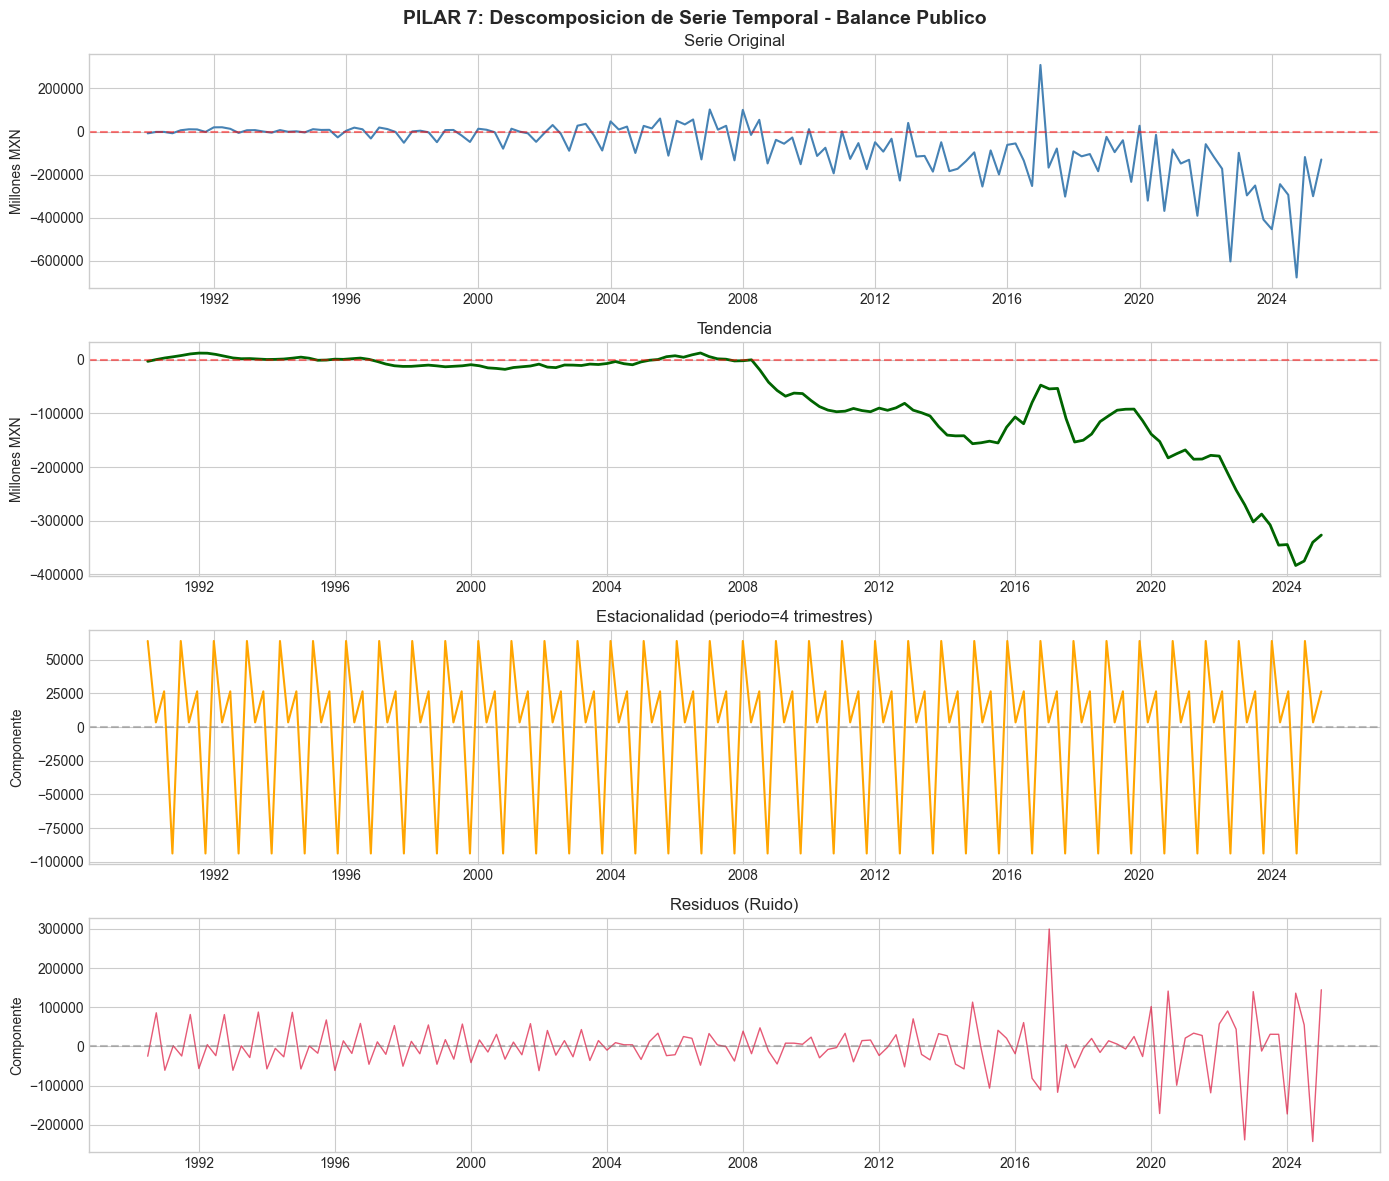


ESTADISTICAS DE COMPONENTES:
  Tendencia - Media: -72644.15 millones MXN
  Estacionalidad - Amplitud: 157613.19 millones MXN
  Residuos - Desv. Std: 66534.25 millones MXN


In [16]:
# Descomposicion de la serie
if len(ts_data.dropna()) >= 8:  # Minimo para descomposicion
    decomposition = seasonal_decompose(ts_data.dropna(), model='additive', period=4)
    
    fig, axes = plt.subplots(4, 1, figsize=(14, 12))
    fig.suptitle('PILAR 7: Descomposicion de Serie Temporal - Balance Publico', fontsize=14, fontweight='bold')
    
    # Original
    axes[0].plot(ts_data, color='steelblue', linewidth=1.5)
    axes[0].axhline(0, color='red', linestyle='--', alpha=0.5)
    axes[0].set_title('Serie Original')
    axes[0].set_ylabel('Millones MXN')
    
    # Tendencia
    axes[1].plot(decomposition.trend, color='darkgreen', linewidth=2)
    axes[1].axhline(0, color='red', linestyle='--', alpha=0.5)
    axes[1].set_title('Tendencia')
    axes[1].set_ylabel('Millones MXN')
    
    # Estacionalidad
    axes[2].plot(decomposition.seasonal, color='orange', linewidth=1.5)
    axes[2].set_title('Estacionalidad (periodo=4 trimestres)')
    axes[2].set_ylabel('Componente')
    axes[2].axhline(0, color='gray', linestyle='--', alpha=0.5)
    
    # Residuos
    axes[3].plot(decomposition.resid, color='crimson', linewidth=1, alpha=0.7)
    axes[3].set_title('Residuos (Ruido)')
    axes[3].set_ylabel('Componente')
    axes[3].axhline(0, color='gray', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # Estadisticas de componentes
    print("\nESTADISTICAS DE COMPONENTES:")
    print(f"  Tendencia - Media: {decomposition.trend.mean():.2f} millones MXN")
    print(f"  Estacionalidad - Amplitud: {decomposition.seasonal.max() - decomposition.seasonal.min():.2f} millones MXN")
    print(f"  Residuos - Desv. Std: {decomposition.resid.std():.2f} millones MXN")
else:
    print("Datos insuficientes para descomposicion (minimo 8 observaciones)")

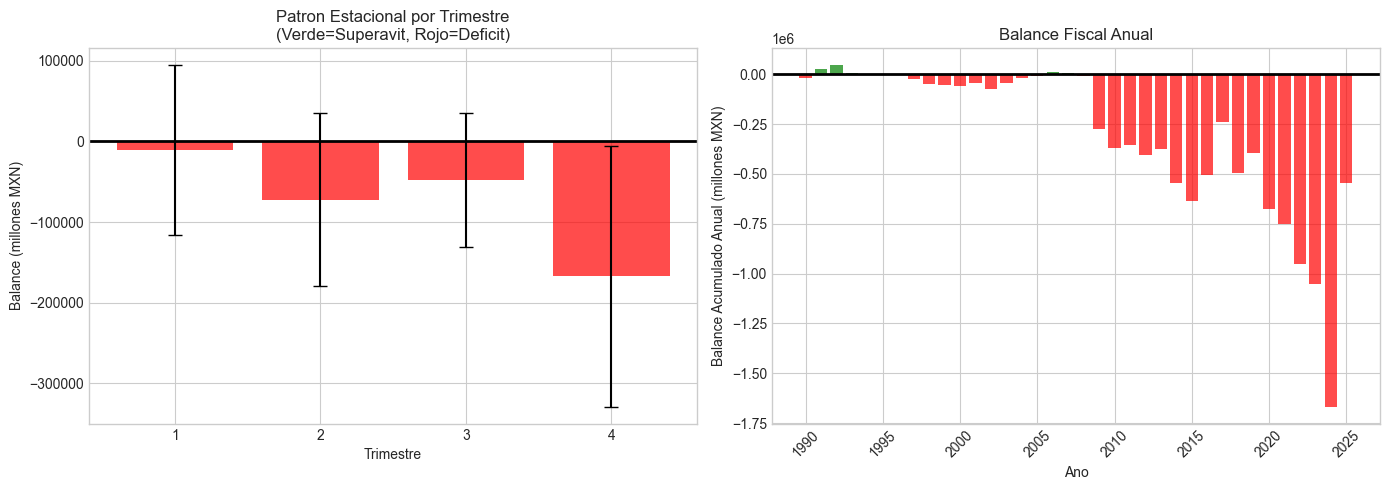

In [17]:
# Patron estacional por trimestre
df['year'] = df['periodo'].dt.year
patron_trimestral = df.groupby('TRIMESTRE')[VAR_PRINCIPAL].agg(['mean', 'std'])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Patron por trimestre
colors = ['green' if m > 0 else 'red' for m in patron_trimestral['mean']]
axes[0].bar(patron_trimestral.index, patron_trimestral['mean'], 
            yerr=patron_trimestral['std'], capsize=5, color=colors, alpha=0.7)
axes[0].axhline(0, color='black', linestyle='-', linewidth=2)
axes[0].set_xlabel('Trimestre')
axes[0].set_ylabel('Balance (millones MXN)')
axes[0].set_title('Patron Estacional por Trimestre\n(Verde=Superavit, Rojo=Deficit)')
axes[0].set_xticks([1, 2, 3, 4])

# Evolucion anual
evolucion_anual = df.groupby('year')[VAR_PRINCIPAL].sum()
colors_anual = ['green' if v > 0 else 'red' for v in evolucion_anual]
axes[1].bar(evolucion_anual.index, evolucion_anual.values, color=colors_anual, alpha=0.7)
axes[1].axhline(0, color='black', linestyle='-', linewidth=2)
axes[1].set_xlabel('Ano')
axes[1].set_ylabel('Balance Acumulado Anual (millones MXN)')
axes[1].set_title('Balance Fiscal Anual')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

---
## PILAR 8: ANOVA - ¿Que estrategia es mejor?

**Objetivo:** Comparar rendimiento entre grupos objetivamente.

In [18]:
# ============================================================================
# PILAR 8: ANOVA - COMPARACION ENTRE GRUPOS
# ============================================================================

print("PILAR 8: ANALISIS DE VARIANZA (ANOVA)")
print("="*80)

# Analisis 1: Comparar balance entre trimestres
print("\n--- ANOVA 1: Balance por Trimestre ---")
print("H0: El balance es igual en todos los trimestres")
print("H1: Al menos un trimestre tiene balance diferente")

grupos_trim = [df[df['TRIMESTRE'] == t][VAR_PRINCIPAL].dropna() for t in [1, 2, 3, 4]]

# ANOVA de una via
f_stat, p_anova = stats.f_oneway(*grupos_trim)
print(f"\nEstadistico F: {f_stat:.4f}")
print(f"p-value: {p_anova:.4f}")
print(f"Conclusion: {'RECHAZAR H0' if p_anova < 0.05 else 'NO RECHAZAR H0'} (alfa=0.05)")

# Test no parametrico (Kruskal-Wallis) como alternativa
h_stat, p_kruskal = kruskal(*grupos_trim)
print(f"\nKruskal-Wallis (no parametrico):")
print(f"  Estadistico H: {h_stat:.4f}")
print(f"  p-value: {p_kruskal:.4f}")

PILAR 8: ANALISIS DE VARIANZA (ANOVA)

--- ANOVA 1: Balance por Trimestre ---
H0: El balance es igual en todos los trimestres
H1: Al menos un trimestre tiene balance diferente

Estadistico F: 11.3696
p-value: 0.0000
Conclusion: RECHAZAR H0 (alfa=0.05)

Kruskal-Wallis (no parametrico):
  Estadistico H: 32.8848
  p-value: 0.0000


In [19]:
# Analisis 2: Comparar periodos (decadas)
print("\n--- ANOVA 2: Balance por Decada ---")

df['decada'] = (df['periodo'].dt.year // 10) * 10
decadas = df['decada'].unique()
grupos_decada = [df[df['decada'] == d][VAR_PRINCIPAL].dropna() for d in sorted(decadas)]
grupos_decada = [g for g in grupos_decada if len(g) >= 3]  # Minimo 3 observaciones

if len(grupos_decada) >= 2:
    f_stat2, p_anova2 = stats.f_oneway(*grupos_decada)
    print(f"\nEstadistico F: {f_stat2:.4f}")
    print(f"p-value: {p_anova2:.6f}")
    print(f"Conclusion: {'RECHAZAR H0' if p_anova2 < 0.05 else 'NO RECHAZAR H0'}")
    if p_anova2 < 0.05:
        print("-> Existe diferencia significativa en el balance entre decadas")
else:
    print("Datos insuficientes para comparar decadas")
    p_anova2 = 1.0
    f_stat2 = 0


--- ANOVA 2: Balance por Decada ---

Estadistico F: 38.2716
p-value: 0.000000
Conclusion: RECHAZAR H0
-> Existe diferencia significativa en el balance entre decadas


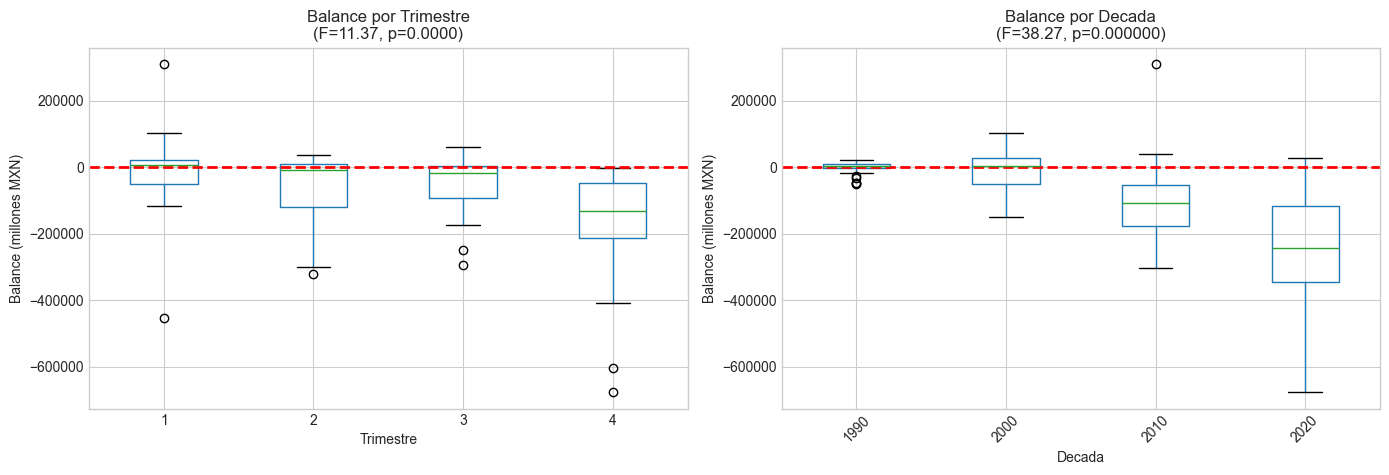

In [20]:
# Visualizacion ANOVA
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('PILAR 8: ANOVA - Comparacion entre Grupos', fontsize=14, fontweight='bold')

# Grafico 1: Boxplot por trimestre
df.boxplot(column=VAR_PRINCIPAL, by='TRIMESTRE', ax=axes[0])
axes[0].axhline(0, color='red', linestyle='--', linewidth=2)
axes[0].set_title(f'Balance por Trimestre\n(F={f_stat:.2f}, p={p_anova:.4f})')
axes[0].set_xlabel('Trimestre')
axes[0].set_ylabel('Balance (millones MXN)')
plt.suptitle('')

# Grafico 2: Boxplot por decada
df.boxplot(column=VAR_PRINCIPAL, by='decada', ax=axes[1])
axes[1].axhline(0, color='red', linestyle='--', linewidth=2)
if len(grupos_decada) >= 2:
    axes[1].set_title(f'Balance por Decada\n(F={f_stat2:.2f}, p={p_anova2:.6f})')
else:
    axes[1].set_title('Balance por Decada')
axes[1].set_xlabel('Decada')
axes[1].set_ylabel('Balance (millones MXN)')
axes[1].tick_params(axis='x', rotation=45)
plt.suptitle('')

plt.tight_layout()
plt.show()

In [21]:
# Estadisticas descriptivas por grupo
print("\nESTADISTICAS POR TRIMESTRE:")
print(df.groupby('TRIMESTRE')[VAR_PRINCIPAL].agg(['count', 'mean', 'std', 'min', 'max']).round(2))

print("\nESTADISTICAS POR DECADA:")
print(df.groupby('decada')[VAR_PRINCIPAL].agg(['count', 'mean', 'std', 'min', 'max']).round(2))


ESTADISTICAS POR TRIMESTRE:
           count       mean        std        min        max
TRIMESTRE                                                   
1             36  -10789.97  105540.09 -452969.18  309068.76
2             36  -72010.89  106892.37 -320184.02   35653.02
3             36  -47579.77   82979.94 -293671.02   60527.16
4             35 -166955.99  161862.90 -676773.05   -1604.62

ESTADISTICAS POR DECADA:
        count       mean        std        min        max
decada                                                   
1990       40   -1470.97   17758.80  -51880.10   19998.42
2000       40  -12922.14   65468.40 -151396.27  102436.35
2010       40 -107826.34  103082.04 -301687.73  309068.76
2020       23 -245581.94  180489.62 -676773.05   26933.22


---
## RESUMEN EJECUTIVO

Sintesis de los hallazgos de los 8 pilares estadisticos.

In [22]:
# ============================================================================
# RESUMEN EJECUTIVO
# ============================================================================

print("="*80)
print("RESUMEN EJECUTIVO: 8 PILARES ESTADISTICOS - BALANCE PUBLICO")
print("="*80)

print("\n1. DISTRIBUCIONES:")
for var in cols_numericas:
    data = df[var].dropna()
    if len(data) >= 20:
        _, p = shapiro(data) if len(data) < 5000 else normaltest(data)
        print(f"   - {var}: {'Normal' if p > 0.05 else 'No Normal'} (p={p:.4f})")

print("\n2. CENTRO DE GRAVEDAD:")
print(f"   - Balance Promedio: {df[VAR_PRINCIPAL].mean():,.0f} millones MXN")
print(f"   - Mediana: {df[VAR_PRINCIPAL].median():,.0f} millones MXN")
balance_promedio = df[VAR_PRINCIPAL].mean()
print(f"   - Tendencia historica: {'DEFICIT' if balance_promedio < 0 else 'SUPERAVIT'}")

print("\n3. FIABILIDAD:")
cv_principal = df[VAR_PRINCIPAL].std() / abs(df[VAR_PRINCIPAL].mean()) * 100
print(f"   - Coeficiente de Variacion: {cv_principal:.1f}%")
print(f"   - Datos {'ESTABLES' if cv_principal < 50 else 'MUY VOLATILES'}")

print("\n4. MARGEN DE ERROR:")
ic_low, ic_high, margen = intervalo_confianza(df[VAR_PRINCIPAL].dropna())
print(f"   - IC 95%: [{ic_low:,.0f}, {ic_high:,.0f}] millones MXN")

print("\n5. PRUEBAS DE HIPOTESIS (Chi-Cuadrada):")
print(f"   - Resultado fiscal vs Trimestre: {'Dependientes' if p_value < 0.05 else 'Independientes'} (p={p_value:.4f})")

print("\n6. PREDICCION (Machine Learning):")
print(f"   - Mejor modelo: {mejor_modelo}")
print(f"   - R2 = {df_resultados.iloc[0]['R2']:.4f}")

print("\n7. SERIES DE TIEMPO:")
print(f"   - Serie {'ESTACIONARIA' if adf_result[1] < 0.05 else 'NO ESTACIONARIA'}")
print(f"   - Patron estacional: Q4 tipicamente con mayor deficit")

print("\n8. ANOVA:")
print(f"   - Diferencia entre trimestres: {'SI' if p_anova < 0.05 else 'NO'} (p={p_anova:.4f})")
if len(grupos_decada) >= 2:
    print(f"   - Diferencia entre decadas: {'SI' if p_anova2 < 0.05 else 'NO'} (p={p_anova2:.6f})")

print("\n" + "="*80)
print("FIN DEL ANALISIS")
print("="*80)

RESUMEN EJECUTIVO: 8 PILARES ESTADISTICOS - BALANCE PUBLICO

1. DISTRIBUCIONES:
   - ingresos_mmxn: No Normal (p=0.0000)
   - gasto_mmxn: No Normal (p=0.0000)
   - balance_mmxn: No Normal (p=0.0000)

2. CENTRO DE GRAVEDAD:
   - Balance Promedio: -73,686 millones MXN
   - Mediana: -32,111 millones MXN
   - Tendencia historica: DEFICIT

3. FIABILIDAD:
   - Coeficiente de Variacion: 176.2%
   - Datos MUY VOLATILES

4. MARGEN DE ERROR:
   - IC 95%: [-95,147, -52,226] millones MXN

5. PRUEBAS DE HIPOTESIS (Chi-Cuadrada):
   - Resultado fiscal vs Trimestre: Dependientes (p=0.0000)

6. PREDICCION (Machine Learning):
   - Mejor modelo: Regresion Lineal
   - R2 = 0.9865

7. SERIES DE TIEMPO:
   - Serie NO ESTACIONARIA
   - Patron estacional: Q4 tipicamente con mayor deficit

8. ANOVA:
   - Diferencia entre trimestres: SI (p=0.0000)
   - Diferencia entre decadas: SI (p=0.000000)

FIN DEL ANALISIS
